# Sparse Autoregressive HMM Demo

We fit an ARHMM where the autoregression weights are given a spike-and-slab ($\ell_0$) prior.
For small numbers of dimensions, we can enumerate all possible sparsity patterns and fit via
maximum marginal likelihood estimation.

## 1. Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

## 2. Create an AR HMM

In [3]:
# Set the parameters of the HMM
time_bins = 10000   # number of time bins
num_states = 5      # number of discrete states
obs_dim = 12         # dimensionality of observation

# Specify the block size for the sparsity pattern
# Both terms must evenly divide `obs_dim`
block_size = (4, 4)

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="sparse_ar", 
                   observation_kwargs=dict(block_size=block_size))

# Zero out some entries of the dynamics matrices
true_hmm.observations.As_mask = npr.rand(*true_hmm.observations.As_mask.shape) < 0.5 
true_hmm.observations.bs = npr.randn(num_states, obs_dim)

## 3. Sample from the HMM

We draw samples from an HMM using the `sample` method:  
`true_states, obs = true_hmm.sample(time_bins)`.  

This returns a tuple $(z, x)$ of the latent states and observations, respectively.
In this case, `true_states` will be an array of size $(200,)$ because it contains the discrete state $z_t$ across $200$ time-bins. `obs` will be an array of size $(200, 2)$ because it contains the observations across $200$ time bins, and each observation is two dimensional.
We have specified the number of time-steps by passing `time_bins` as the argument to the `sample` method.

In the next line, we retrieve the log-likelihood of the data we observed:  
`true_ll = true_hmm.log_probability(obs)`  

This tells us the relative probability of our observations. In the next section, when we fit an HMM to the data we generated, the true log-likelihood will be helpful for determining if our fitting algorithm succeeded.

In [4]:
# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

Text(0.5, 1.0, 'Observation Distributions')

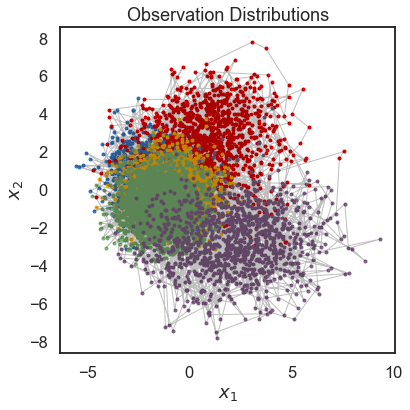

In [5]:
plt.figure(figsize=(6, 6))
for k in range(num_states):
    plt.plot(obs[true_states==k, 0], obs[true_states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(obs[:,0], obs[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the "true" values of the observation variable (the mean) while the solid lines are the actual observations sampled from the HMM.

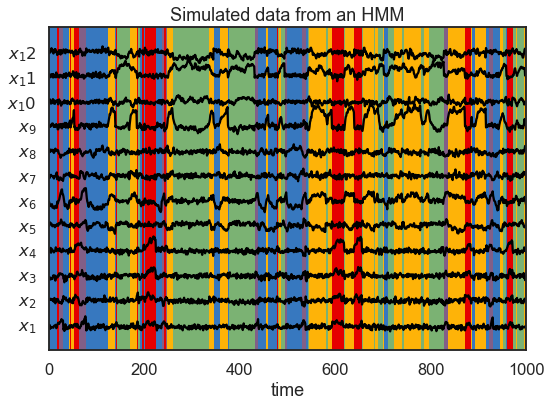

In [6]:
# Plot the data and the smoothed data
lim = 1.05 * abs(obs).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None,:],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))

for d in range(obs_dim):
    plt.plot(obs[:,d] + lim * d, '-k')

plt.xlim(0, min(1000, time_bins))
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

plt.title("Simulated data from an HMM")

plt.tight_layout()

# 4. Fit an HMM to synthetic data
This is all fine, but so far we haven't done anything that useful. It's far more interesting to learn an HMM from data. In the following cells, we'll use the synthetic data we generated above to fit an HMM from scratch. This is done in the following lines:

`
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
hmm_lls = hmm.fit(obs, method="em", num_em_iters=N_iters)
`

In the first line, we create a new HMM instance called `hmm` with a gaussian observation model, as in the previous case. Because we haven't specified anything, the transition probabilities and observation means will be randomly initialized. In the next line, we use the `fit` method to learn the transition probabilities and observation means from data. We set the method to `em` (expectation maximization) and specify the maximum number of iterations which will be used to fit the data. The `fit` method returns a numpy array which shows the log-likelihood of the data over time. We then plot this and see that the EM algorithm quickly converges.

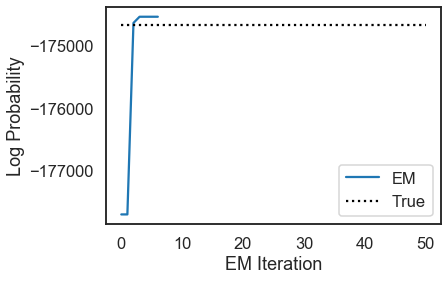

In [7]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 50

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="sparse_ar",
              observation_kwargs=dict(block_size=block_size))

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, tolerance=1e-3)

plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

The below cell is a bit subtle. In the first section, we sampled from the HMM and stored the resulting latent state $z$ in a variable called `state`. 
Now, we are treating our observations from the previous section as data, and seeing whether we can infer the true state given only the observations. However, there is no guarantee that the states we learn correspond to the original states from the true HMM. In order to account for this, we need to find a permutation of the states of our new HMM so that they align with the states of the true HMM from the prior section. This is done in the following two lines:

`most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))
`  
  
In the first line, we use the `most_likely_states` method to infer the most likely latent states given the observations.  In the second line we call the `find_permutation` function the permutation that best matches the true state. We then use the `permute` method on our `hmm` instance to permute its states accordingly.



In [8]:
# Find a permutation of the states that best matches the true and inferred states
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

Below, we plot the inferred states ($z_{\mathrm{inferred}}$) and the true states ($z_{\mathrm{true}}$) over time. We see that the two match very closely, but not exactly. The model sometimes has difficulty inferring the state if we only observe that state for a very short time.

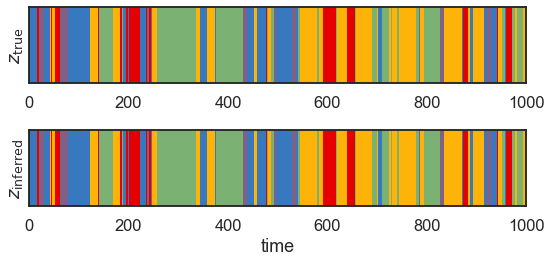

In [9]:
# Plot the true and inferred discrete states
hmm_z = hmm.most_likely_states(data)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, min(1000, time_bins))
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, min(1000, time_bins))
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

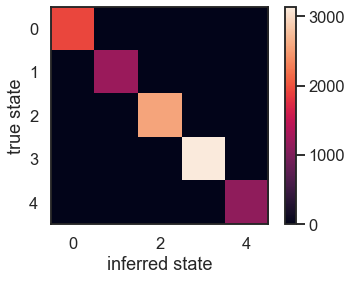

In [10]:
# Compute state overlap
from ssm.util import compute_state_overlap
overlap = compute_state_overlap(true_states, hmm_z)
plt.imshow(overlap)
plt.xlabel("inferred state")
plt.ylabel("true state")
plt.colorbar()

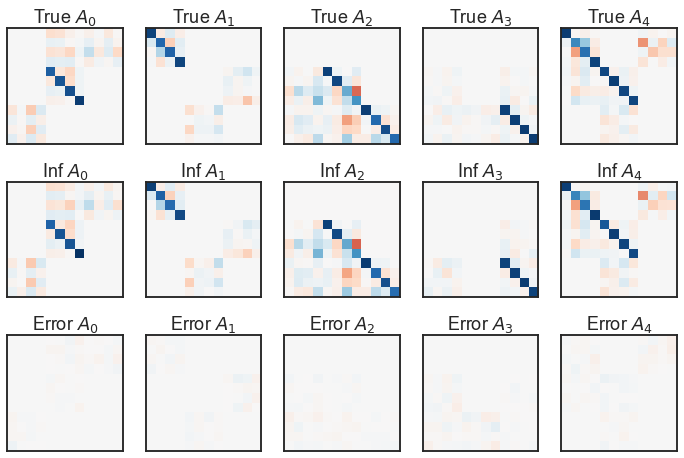

In [11]:
# Plot the A matrices
Alim = 1.05 * abs(true_hmm.observations.As).max()
fig, axs = plt.subplots(3, num_states, figsize=(12, 8))
for k in range(num_states):
    axs[0, k].imshow(true_hmm.observations.As[k], 
                     vmin=-Alim, vmax=Alim, cmap="RdBu")
    axs[0, k].set_title("True $A_{}$".format(k))
    axs[0, k].set_xticks([])
    axs[0, k].set_yticks([])

    axs[1, k].imshow(hmm.observations.As[k], 
                     vmin=-Alim, vmax=Alim, cmap="RdBu")
    axs[1, k].set_title("Inf $A_{}$".format(k))
    axs[1, k].set_xticks([])
    axs[1, k].set_yticks([])
    
    axs[2, k].imshow(true_hmm.observations.As[k] - hmm.observations.As[k], 
                     vmin=-Alim, vmax=Alim, cmap="RdBu")
    axs[2, k].set_title("Error $A_{}$".format(k))
    axs[2, k].set_xticks([])
    axs[2, k].set_yticks([])

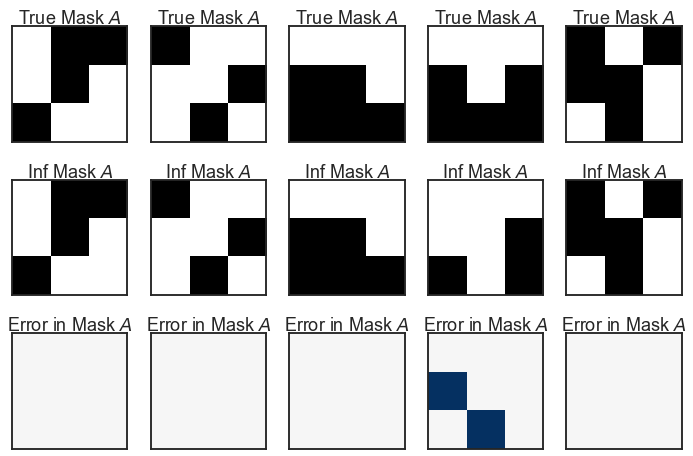

In [12]:
# Plot the A masks
fig, axs = plt.subplots(3, num_states, figsize=(12, 8))
for k in range(num_states):
    axs[0, k].imshow(true_hmm.observations.As_mask[k],
                     vmin=0, vmax=1, cmap="Greys")
    axs[0, k].set_title("True Mask $A_{{}}$".format(k))
    axs[0, k].set_xticks([])
    axs[0, k].set_yticks([])

    axs[1, k].imshow(hmm.observations.As_mask[k], 
                     vmin=0, vmax=1, cmap="Greys")
    axs[1, k].set_title("Inf Mask $A_{{}}$".format(k))
    axs[1, k].set_xticks([])
    axs[1, k].set_yticks([])
    
    axs[2, k].imshow(true_hmm.observations.As_mask[k].astype(int) - hmm.observations.As_mask[k].astype(int), 
                     vmin=-1, vmax=1, cmap="RdBu")
    axs[2, k].set_title("Error in Mask $A_{{}}$".format(k))
    axs[2, k].set_xticks([])
    axs[2, k].set_yticks([])

(0, 1000)

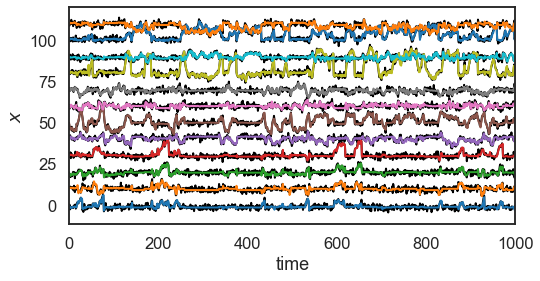

In [13]:
# Use the HMM to "smooth" the data
hmm_x = hmm.smooth(obs)

plt.figure(figsize=(8, 4))
plt.plot(obs + 10 * np.arange(obs_dim), '-k', lw=2)
plt.plot(hmm_x + 10 * np.arange(obs_dim), '-', lw=2)
plt.xlim(0, time_bins)
plt.ylabel("$x$")
plt.xlabel("time")
plt.xlim(0, 1000)

### 4.1. Visualize the Transition Matrices
The dynamics of the hidden state in an HMM are specified by the transition probabilities $p(z_t \mid z_{t-1})$. It's standard to pack these probabilities into a stochastic matrix $A$ where $A_{ij} = p(z_t = j \mid z_{t-1} = i)$.

In SSM, we can access the transition matrices using `hmm.transitions.transition` matrix. In the following two lines, we retrives the transition matrices for the true HMM, as well as the HMM we learned from the data, and compare them visually.

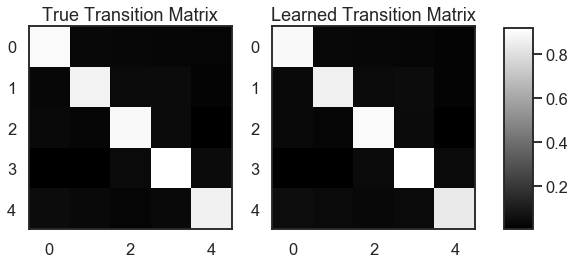

In [14]:
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


### 4.3: Visualize State Durations


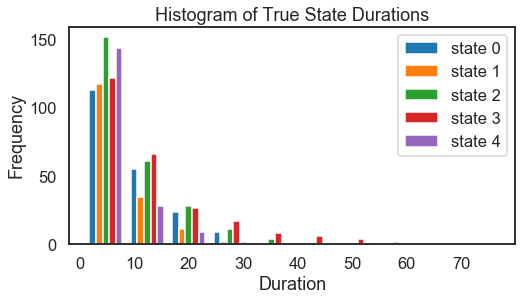

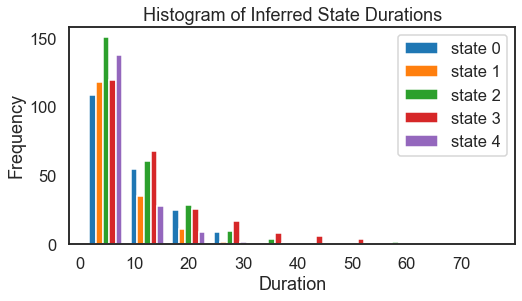

In [15]:
true_state_list, true_durations = ssm.util.rle(true_states)
inferred_state_list, inferred_durations = ssm.util.rle(hmm_z)

# Rearrange the lists of durations to be a nested list where
# the nth inner list is a list of durations for state n
true_durs_stacked = []
inf_durs_stacked = []
for s in range(num_states):
    true_durs_stacked.append(true_durations[true_state_list == s])
    inf_durs_stacked.append(inferred_durations[inferred_state_list == s])
    
fig = plt.figure(figsize=(8, 4))
plt.hist(true_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of True State Durations')

fig = plt.figure(figsize=(8, 4))
plt.hist(inf_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Inferred State Durations')

plt.show()